## Importando as bibliotecas:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import random

/home/felipe/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Carregando o dataset e fazendo as configuracoes iniciais:

A funcao trasnforms.Compose([]) eh responsavel por aplicar uma serie de transformacoes e conversoes
nas imagens antes de passar para a rede neural, no caso, estamos aplicando somente a conversao para tensor.

Estamos usando o dataset MNIST, que possui dimensoes de exatamente 28x28. Estamos tambem fazendo uma divisao de 80%
do dataset para treino e 20% para teste do modelo alem de um random_split no proprio dataset, o que nao eh necessariamente otimo
pois existe uma chance de enviesar o modelo desbalanceando a distribuicao de numeros entre as secoes de teste e treino.

O batch size foi definido como 128, o que significa que o modelo somente ajustara os pesos apos 128 imagens vistas.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

image_dims_color = 28*28
batch_size = 128

dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


## Declarando a classe do VAE:

No construtor da classe estamos criando as camadas do VAE, note que ate as camadas fc51 e fc52 estamos reduzindo o numero de neuronios e por consequencia
reduzindo o espaco latente, buscando resumir os dados a suas distribuicoes. Ja nas camadas posteriores as citadas anteriormente estamos aumentando novamente
o numero de neuronios, aumentando o espaco latente. Estamos usando a ReLU como funcao de ativacao para todas as camadas (com excecao da camada de saida onde estamos usando a funcao sigmoid).

Outro fator importante de se notar eh que as camadas fc51 e fc52 estao sendo usadas como media e variancia da distribuicao gaussiana construida apartir dos dados de entrada, no caso as imagens do dataset MNIST.

O metodo forward eh simplesmente onde ocorre a planificacao do espaco multidimensional, a reducao do espaco latente para criar a distribuicao gaussiana dos dados de entrada por parte do encoder e a reconstrucao dos dados de entrada por parte do decoder, ou seja, ele planifica os dados e passa por todas as camadas da rede neural (encoder e decoder).

O metodo reparameterize eh responsavel justamente por coletar amostras da distribuicao normal dos dados de acordo com a media e a variancia obtidas na parte de encode,
o que torna o ajuste dos pesos usando o gradiente descendente possivel.

Por fim, o metodo decode recebe as amostras coletadas pela funcao reparameterize e tenta reconstruir os dados de entrada passando eles pela outra metade das camadas da rede neural.

In [3]:
class VAE(nn.Module):
    def __init__(self, image_dims_color):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_dims_color, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc51 = nn.Linear(64, 20)  # mean
        self.fc52 = nn.Linear(64, 20)  # log variance
        self.fc6 = nn.Linear(20, 64)
        self.fc7 = nn.Linear(64, 128)
        self.fc8 = nn.Linear(128, 256)
        self.fc9 = nn.Linear(256, 512)
        self.fc10 = nn.Linear(512, image_dims_color)
    
    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))
        h4 = torch.relu(self.fc4(h3))
        return self.fc51(h4), self.fc52(h4)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        h6 = torch.relu(self.fc6(z))
        h7 = torch.relu(self.fc7(h6))
        h8 = torch.relu(self.fc8(h7))
        h9 = torch.relu(self.fc9(h8))
        return torch.sigmoid(self.fc10(h9))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, image_dims_color))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

## Construcao da funcao de perda do modelo:

Para a funcao de perda estamos usando binary cross entropy (BCE) em conjunto com o KL divergence (KLD), onde o BCE eh usado para saber o quao bem o auto encoder esta classificando os tensores gerados a partir do espaco latente pelo encoder. Ja o KLD esta sendo usado para medir a divergencia entre a distribuicao latente aprendida pelo encoder e a istribuicao gaussiana padrao N(0, 1).

In [4]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, image_dims_color), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

## Configurando o uso da placa de video e o modelo:

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = VAE(image_dims_color).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.5, 0.999))

specific_image, _ = train_dataset[0]
specific_image = specific_image.to(device).view(-1, image_dims_color)

model.train()
num_epochs = 50
reconstructions = []

cuda


## Treinamento:
(salvando os pesos do modelo em cada epoca)

Epoch 1, Loss: 177.3443203531901
Epoch 2, Loss: 152.0612714029948
Epoch 3, Loss: 139.87108408610027
Epoch 4, Loss: 134.91653963216146
Epoch 5, Loss: 131.7989021809896
Epoch 6, Loss: 129.56624894205729
Epoch 7, Loss: 127.7750433959961
Epoch 8, Loss: 126.44019822184245
Epoch 9, Loss: 125.29681370035807
Epoch 10, Loss: 124.3269639892578
Epoch 11, Loss: 123.59574473063151
Epoch 12, Loss: 122.79325500488281
Epoch 13, Loss: 122.21068619791667
Epoch 14, Loss: 121.6830088704427
Epoch 15, Loss: 121.11457169596355
Epoch 16, Loss: 120.72316103108724
Epoch 17, Loss: 120.23866343180339
Epoch 18, Loss: 119.77948034667969
Epoch 19, Loss: 119.38409193929037
Epoch 20, Loss: 119.04990043131511
Epoch 21, Loss: 118.70446555582683
Epoch 22, Loss: 118.44466603597006
Epoch 23, Loss: 118.14475630696614
Epoch 24, Loss: 117.99766101074219
Epoch 25, Loss: 117.6763061319987
Epoch 26, Loss: 117.43288242594402
Epoch 27, Loss: 117.15913177490235
Epoch 28, Loss: 116.84478086344402
Epoch 29, Loss: 116.64886486816407
E

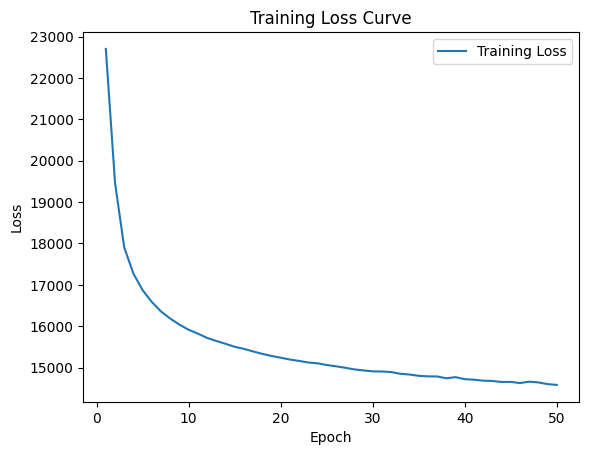

In [7]:
train_loss_values = []

for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    average_train_loss = train_loss / len(train_loader)
    train_loss_values.append(average_train_loss)

    torch.save(model.state_dict(), f'./epochs/vae_epoch_{epoch + 1}.pth')
    
    model.eval()
    with torch.no_grad():
        recon_image, _, _ = model(specific_image)
        reconstructions.append(recon_image.view(28, 28).cpu().numpy())
    model.train()
    
    print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}')

plt.plot(range(1, num_epochs+1), train_loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

## Gerando imagens:

50


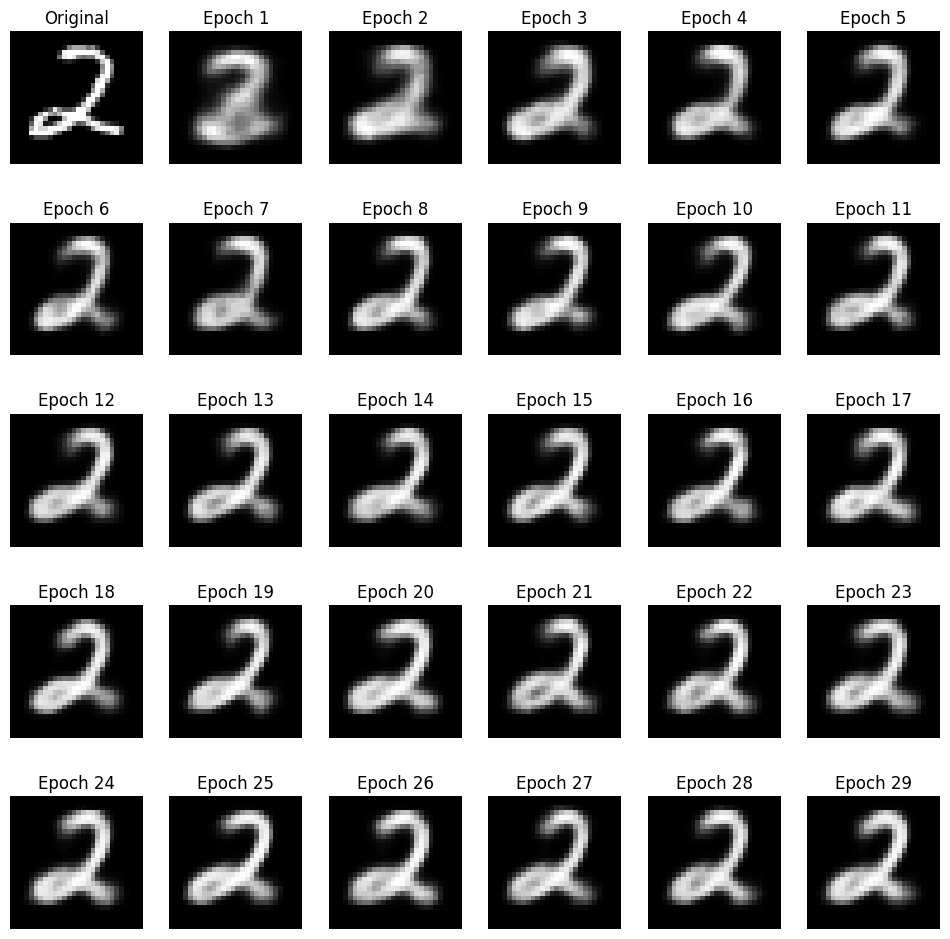

In [11]:
def predict(image, num_epochs):
    print(num_epochs)
    image = image.to(device).view(-1, image_dims_color)
    predictions = []
    for epoch in range(1, num_epochs + 1):
        model.load_state_dict(torch.load(f'./epochs/vae_epoch_{epoch}.pth'))
        model.eval()
        with torch.no_grad():
            recon_image, _, _ = model(image)
            predictions.append(recon_image.view(28, 28).cpu().numpy())
    return predictions

model.eval()
with torch.no_grad():
    z = torch.randn(64, 20).to(device)
    sample = model.decode(z).cpu()
    sample = sample.view(64, 28, 28)

specific_image, _ = test_dataset[random.choice(range(0, test_size))]
predictions = predict(specific_image, num_epochs)

fig, ax = plt.subplots(5, 6, figsize=(12, 12))
ax = ax.flatten()
ax[0].imshow(specific_image.view(28, 28).cpu(), cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

for i in range(1, 30):
    ax[i].imshow(predictions[i-1], cmap='gray')
    ax[i].set_title(f'Epoch {i}')
    ax[i].axis('off')

plt.show()


## Gerando uma imagem do VAE:

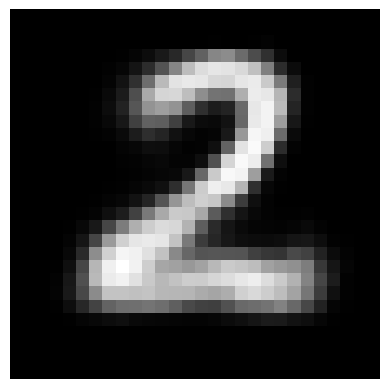

In [17]:
def generate_image(model, device):
    model.eval()
    model.load_state_dict(torch.load(f'./epochs/vae_epoch_30.pth'))
    with torch.no_grad():
        z = torch.randn(1, 20).to(device)
        sample = model.decode(z).cpu()
        sample = sample.view(28, 28)
        return sample

# for i in range(0, 5000):
#     image, _ = test_dataset[random.choice(range(0, test_size))]
#     plt.imshow(image.view(28, 28), cmap='gray')
#     plt.axis('off')
#     plt.savefig('images_mnist/image_mnist{}'.format(i), bbox_inches='tight', pad_inches=0)
#     plt.close()

image = generate_image(model, device)
plt.imshow(image.view(28, 28), cmap='gray')
plt.axis('off')
plt.show()